In [2]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import soa_jens as SOA
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d

# load CSV
df = pd.read_csv("generalized_forces.csv")

# extract time
t_data = df["time"].to_numpy()

tau_data = df[
    [
        "body_1_moment_x",
        "body_1_moment_y",
        "body_1_moment_z",
        "body_2_moment",
        "body_3_moment",
        "body_4_moment_x",
        "body_4_moment_y",
        "body_4_moment_z",
    ]
].to_numpy()  # shape (N, 8)

tau_interp = interp1d(
    t_data,
    tau_data,
    axis=0,
    kind="linear",
    fill_value="extrapolate",  # or (0,0) if you prefer
)

def tau_vec_from_csv(t):
    tau8 = tau_interp(t)        # length 8
    tau14 = np.zeros(14)

    tau14[0:3]   = tau8[0:3]    # body 1
    tau14[3]     = tau8[3]      # body 2
    tau14[4]     = tau8[4]      # body 3
    tau14[5:8]   = tau8[5:8]    # body 4
    # body 5: no applied forces

    return tau14

       
def ATBI(state,tau_vec,n):
        #inputs
        #state: np.array on form [theta_dot, beta]
        #tau_vec: generalized forces as np.array
        #l_hinge: vector from O_k to O+_k-1 in k frame (this doesnt matter as they are identical in our case)
        #m: mass of length. Ensure that you dont have a very long and slender link with a small mass to avoid very stiff elements
        #type: hinge-type for all links. Right now its purely spherical that is implemented
        #n: no_bodies
        #link: Instantiate a link using the SimpleLink class and pass it
        #outputs beta_dot

        #unpacking state
        theta_vec = state[:17]
        beta_vec  = state[17:]

        quat = [None]*(n+2)
        beta  = [None]*(n+2)
        tau   = [None]*(n+2)

        # boundary conditions - det kan diskuteres om man behøver i begge ender for dem alle, det gør man vidst nok ikke
        quat[0]   = np.zeros(4)
        quat[n+1] = np.zeros(4)

        beta[0]    = np.zeros(3)
        beta[n+1]  = np.zeros(3)

        tau[0]     = np.zeros(3)
        tau[n+1]   = np.zeros(3)

        #unpacking interior (actually transforming all to quarternions lol), so maybe theta should be renamed to q
        quat[1] = theta_vec[:4] 
        quat[2] = SOA.quatfromrev(theta_vec[4],"x")
        quat[3]=  SOA.quatfromrev(theta_vec[5],"x")
        quat[4] = theta_vec[6:10]  
        quat[5] = theta_vec[10:14] 

        #unpacking beta
        beta[1] = beta_vec[:3]
        beta[2] = beta_vec[3:4]
        beta[3] = beta_vec[4:5]
        beta[4] = beta_vec[5:8]
        beta[5] = beta_vec[8:14]

        #same for tau
        tau[1] = tau_vec[:3]
        tau[2] = tau_vec[3:4]
        tau[3] = tau_vec[4:5]
        tau[4] = tau_vec[5:8]
        tau[5] = tau_vec[8:14]

        #storage
        P_plus = [None]*(n+2)
        xi_plus = [None]*(n+2)
        nu = [None]*(n+2)
        A = [None]*(n+2)
        V = [None]*(n+2)
        G = [None]*(n+2)
        D = [None]*(n+2)
        beta_dot = [None]*(n+2)
        tau_bar = [None]*(n+2)
        agothic = [None]*(n+2)
        bgothic = [None]*(n+2)
        
        #gravity and storage of gravity
        g = [None]*(n+2)
        g[n+1] = np.array([0,0,0,0,0,0*9.81]) #in inertial frame 

        #boundary conditions on spatial operator quantities
        P_plus[0] = np.zeros((6,6))
        xi_plus[0] = np.zeros((6,))
        tau_bar[0] = P_plus[0]
        A[n+1] = np.array([0, 0, 0, 0, 0, 0])
        V[n+1] = np.zeros((6,))


        #physical quantities
        m = [None]*(n+2)
        RBT = [None]*(n+2)
        J = [None]*(n+2)
        l_com = [None]*(n+2)
        l_hinge = [None]*(n+2)
        H = [None]*(n+2)

        #filling out quantities
        m[1],m[2],m[3],m[4],m[5] = 14520, 400, 400, 400, 294000
        l_com[1],l_com[2],l_com[3],l_com[4],l_com[5], = np.array([0,0,0.7]),np.array([0,0,2.5]),np.array([0,0,2.5]),np.array([0,0,2.5]),np.zeros(3)
        l_hinge[1],l_hinge[2],l_hinge[3],l_hinge[4],l_hinge[5],l_hinge[6] = np.array([0,0,0]),np.array([0,0,5]),np.array([0,0,5]),np.array([0,0,5]),np.array([12,4,2]),np.array([0,0,0])
        J[1],J[2],J[3],J[4],J[5] = np.diag([1.01,1.51,0.331])*10**4, np.diag([834,834,0.72]),np.diag([834,834,0.72]),np.diag([834,834,0.72]),np.diag([3.87,29.04,30.30])*10**6
        
        H[1] = np.block([np.eye(3), np.zeros((3, 3))])
        H[2] = np.array([[1, 0, 0, 0, 0, 0]])
        H[3] = H[2]
        H[4] = H[1]
        H[5] = np.eye(6)


        #kinematics scatter

        for k in range(n,0,-1):
            #rotation matrices
            pRc = SOA.spatialrotfromquat(quat[k]) 
            cRp = pRc.T #from parent to child -> this is the direction we are going right now

            RBT = SOA.RBT(l_hinge[k+1])

            #rotating gravity such that we have that in frame aswell
            g[k] = cRp@g[k+1]

            #hinge contribtuion
            delta_V = H[k].T @ beta[k]

            #spatial velocity
            V[k] = cRp @ RBT.T @ V[k+1] + delta_V

            #coriolois acc
            agothic[k] = SOA.spatialskewtilde(V[k]) @ H[k].T @ beta[k] - SOA.spatialskewbar(H[k].T @ beta[k]) @ (H[k].T @ beta[k]) #fejl kan evt også være her
            

        #ATBI gather 
        for k in range(1,n+1): #n+1 as python does not include end index

            #rotations
            pRc = SOA.spatialrotfromquat(quat[k-1]) #using k-1 as orientation is defined as k+1_q_k and we need k_q_k-1
            cRp = pRc.T 

            RBT = SOA.RBT(l_hinge[k])
            RBT_COM = SOA.RBT(l_com[k]) #hvis noget galt kig her

            M_c = np.block([
                            [J[k], np.zeros((3,3))],
                            [np.zeros((3,3)), m[k]*np.eye(3)]])

            
            M = RBT_COM@M_c@RBT_COM.T

            #gyroscopic term
            bgothic[k] = SOA.spatialskewbar(V[k]) @ M @ V[k]
        
            P = RBT @ pRc @ P_plus[k-1] @ cRp@RBT.T + M
            D[k] = H[k] @ P @ H[k].T
            G[k] = np.linalg.solve(D[k], H[k] @ P).T #P @ link.H.T @ np.linalg.inv(D)
            tau_bar[k] = np.eye(6) - G[k] @ H[k]
            P_plus[k] = tau_bar[k] @ P
            xi = RBT @ pRc @ xi_plus[k-1] + P @ agothic[k] + bgothic[k]
            eps = tau[k] - H[k]@xi
            nu[k] = np.linalg.solve(D[k], eps) #= np.linalg.inv(D)@eps
            xi_plus[k] = xi + G[k]@eps

        #ATBI scatter
        for k in range(n,0,-1):
            #rotations
            pRc = SOA.spatialrotfromquat(quat[k])
            cRp = pRc.T 

            RBT = SOA.RBT(l_hinge[k+1])


            A_plus = cRp@ RBT.T @A[k+1]
            nu_bar = nu[k] - G[k].T @ g[k]  
            beta_dot[k] = (nu_bar - G[k].T @ A_plus).reshape(-1)
            A[k] = A_plus + H[k].T @ beta_dot[k] + agothic[k]
            

        return A, V, beta_dot #which is theta_ddot depending on how you look at it
    

In [3]:
def odefun(t, state,n):
    #solve_ivp passes state as np.array. It is unpacked, and then passed to ATBI as a a list of form state = [theta,beta].

    #unpacking state
    theta = state[:17]
    beta = state[17:]

    #normalizing quartenions
    #SOA.normalize_quaternions(theta)

 
    tau_vec  = tau_vec_from_csv(t) 


    #Calculationg of generalized accelerations (beta_dot) - this requires ATBI. 
    A, V, beta_dot_list = ATBI(state, tau_vec,n)
    V5 = V[5] #spatial velocity of 5th vody
        
    #calculating theta_dot based on the derrivmap function
    theta_dot = np.zeros(len(theta))
    theta_dot[:4] = SOA.derrivmap(theta[:4],beta[:3],"spherical").flatten()
    theta_dot[4:5] = SOA.derrivmap(theta[4],beta[3],"revolute")
    theta_dot[5:6] = SOA.derrivmap(theta[5],beta[4],"revolute")
    theta_dot[6:10] = SOA.derrivmap(theta[6:10],beta[5:8],"spherical")  .flatten()
    theta_dot[10:14] = SOA.derrivmap(theta[10:14],beta[8:11],"spherical").flatten()
    theta_dot[14:17] = SOA.rotfromquat(theta[10:14]) @ beta[11:14] 

        
    beta_dot = np.zeros(14)
    beta_dot[:3] = beta_dot_list[1].flatten()
    beta_dot[3:4] = beta_dot_list[2].flatten()
    beta_dot[4:5] = beta_dot_list[3].flatten()
    beta_dot[5:8] = beta_dot_list[4].flatten()
    beta_dot[8:14] = beta_dot_list[5].flatten()
    
    state_dot = np.concatenate([theta_dot, beta_dot])

    return state_dot




In [11]:
# Solve the ODE using scipy's solve_ivp
n = 5
#initial config
theta0 = np.array([0,0,0,1,np.pi/4,np.pi/4,0,0,0,1,0,0,0,1,0,0,0])
beta0 = np.zeros(14)
state0 = np.concatenate([theta0,beta0])

# manually call odefun at t=0
state_dot_test = odefun(0, state0, n)


tspan = np.arange(0, 1000,1)
result = solve_ivp(
    odefun, 
    t_span=(0, tspan[-1]), 
    y0=state0, 
    method='RK45',
    t_eval = tspan,
    args=(n,)
     )
            # Extract time and state vectors




(31,)

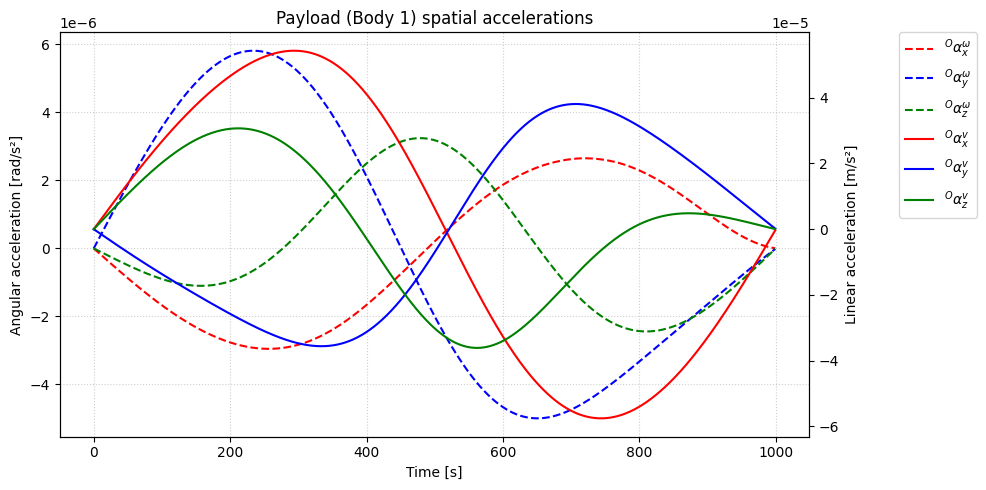

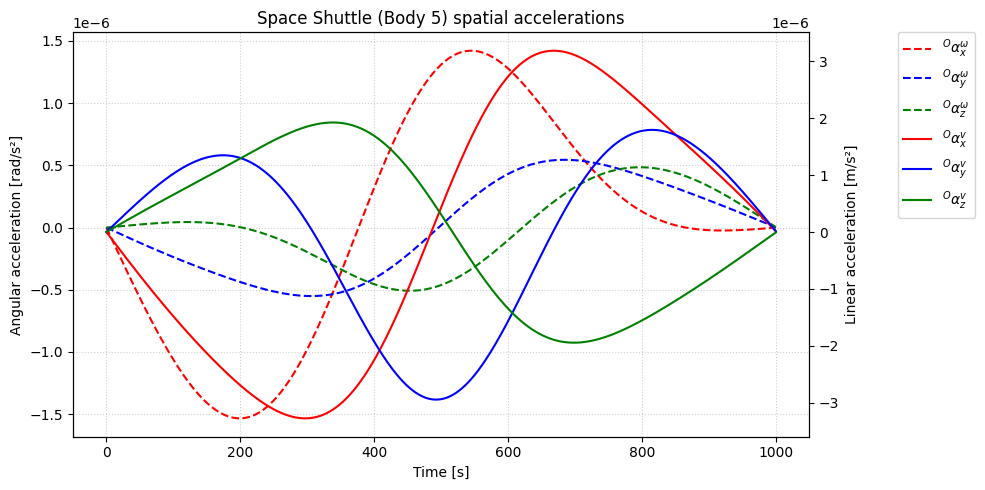

In [12]:
def plot_spatial_accelerations(time, alpha_data, body_name):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Angular Accelerations (dashed lines)
    lns1 = ax1.plot(time, alpha_data[0, :], 'r--', label=r'$^{O}\alpha_x^\omega$')
    lns2 = ax1.plot(time, alpha_data[1, :], 'b--', label=r'$^{O}\alpha_y^\omega$')
    lns3 = ax1.plot(time, alpha_data[2, :], 'g--', label=r'$^{O}\alpha_z^\omega$')

    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Angular acceleration [rad/s²]')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Linear Accelerations (solid lines)
    ax2 = ax1.twinx()
    lns4 = ax2.plot(time, alpha_data[3, :], 'r-', label=r'$^{O}\alpha_x^v$')
    lns5 = ax2.plot(time, alpha_data[4, :], 'b-', label=r'$^{O}\alpha_y^v$')
    lns6 = ax2.plot(time, alpha_data[5, :], 'g-', label=r'$^{O}\alpha_z^v$')

    ax2.set_ylabel('Linear acceleration [m/s²]')
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Combine legends
    lns = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0.)

    plt.title(f'{body_name} spatial accelerations')
    plt.tight_layout()
    plt.show()


# --- Extract alpha (spatial accelerations) for body 1 and 5 ---
time_points = result.t
num_steps = len(time_points)
A1 = np.zeros((6, num_steps))
A5 = np.zeros((6, num_steps))

for i in range(num_steps):
    t = time_points[i]
    state = result.y[:, i]   # get the state vector at this timestep
    tau_vec = tau_vec_from_csv(t)
    
    A, V, beta_dot_list = ATBI(state, tau_vec, n)
    
    # Store body 1 and 5 spatial accelerations
    A1[:, i] = np.array(A[1]).flatten()
    A5[:, i] = np.array(A[5]).flatten()


# --- Now plot using the same plotting function ---
plot_spatial_accelerations(time_points, A1, "Payload (Body 1)")
plot_spatial_accelerations(time_points, A5, "Space Shuttle (Body 5)")
